# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Valentin Kindschi"
student2 = "Antoine Hoffmann"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

from scipy.optimize import fsolve
import json

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(234445+236838)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

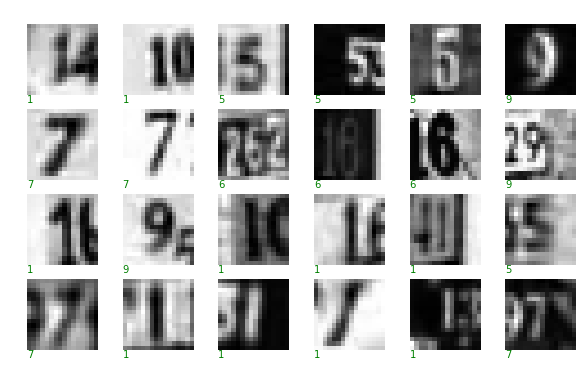

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [53]:
#Optimization of a monolayer neural network with SGD and lr=0.1
batch_size = 128
num_classes = 5
epochs = 500

model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_dim=x_train.shape[1]))

sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 0,
                    validation_data = (x_test, y_test))

yhat_test = model.predict(x_test, 
                          batch_size=batch_size,
                          verbose=0)

score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.summary()

Test loss: 1.5225906127
Test accuracy: 0.434832491969
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


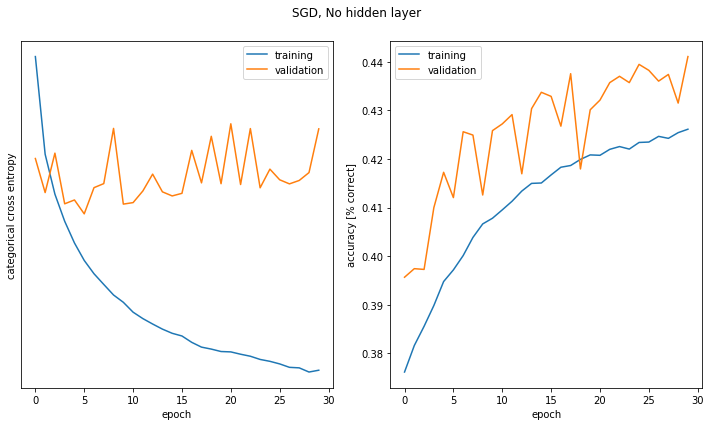

In [50]:
plot_history(history, 'SGD, No hidden layer');

Number of pattern :  13074
Size of error_indices :  7410
Error in % :  0.5667737494263424


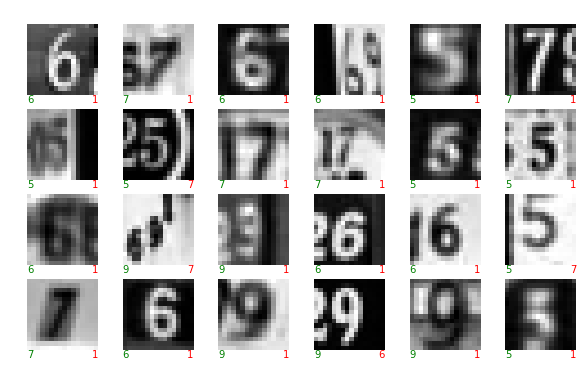

In [34]:
nb_pattern = y_test.shape[0]
#Construction of a list containing the indices of network's wrong answers 
error_indices = []
#for i in range(int(y_test.size/y_test[1].size)): #y_test.size/y_test[1].size c'est peut-être pas très élégant...
for i in range(0,nb_pattern):
    answer_nn = 0
    answer = 0
    for j in range(0, 4):
        if(y_test[i][answer] < y_test[i][j]): # Looking for the maximal value to get the answer index
            answer = j   
        if(yhat_test[i][answer_nn] < yhat_test[i][j]):
            answer_nn = j
            
    if(answer_nn!=answer): # Comparing the answer of y and yhat, adding the pattern index if not correct
        error_indices.append(i)
        
print("Number of pattern : ",nb_pattern)
print("Size of error_indices : ", len(error_indices))
print("Error in % : ", len(error_indices)/nb_pattern)
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes);

In [11]:
#error_indices = [x for x in y_te
#answer = np.zeros_like(yhat_test) #create a matrix of zeros with the same shape as yhat_test
#answer[np.arange(len(yhat_test)),yhat_test.argmax(1)]=1 #set to 1 the max of each row

#error_indices = np.argwhere(np.sum(np.equal(answer,y_test),axis=1)==5) #not working yet
#plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [16]:
#Ex 2. Parameters initialization
batch_size = 128
num_classes = 5
epochs = 50
hidden_neurons = 64

SGD Optimizer:

In [8]:
#Optimization of a neural network with one hidden layer and SGD. Tunable learning rate.
def SGD_learning_rate(lr,SUM=False):
    
    model = Sequential()
    model.add(Dense(hidden_neurons, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dense(num_classes, activation='softmax'))

    sgd = keras.optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)

    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 0,
                            validation_data = (x_test, y_test))
    if (SUM): model.summary()
    return history

In [48]:
#test
SGD_learning_rate(0.1,SUM=True);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


Analyse impact of learning rate on SGD Optimizer:

In [49]:
#different learning rates tested
lr = [0.001, 0.01, 0.1, 1.0, 10.0]

history_lr = {}
for i in lr:
    history_lr[i] = SGD_learning_rate(i,SUM=False).history

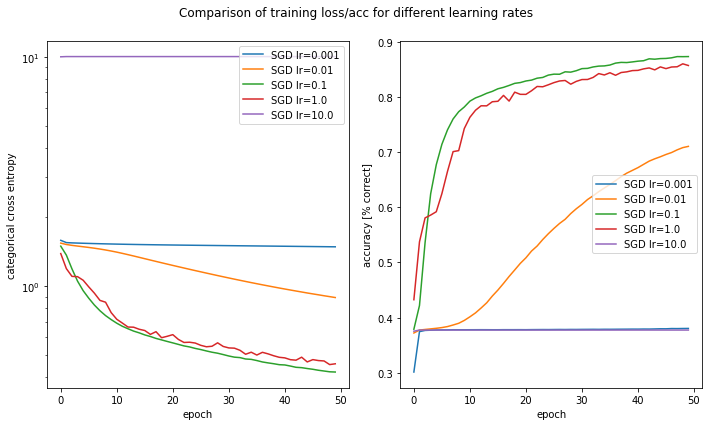

In [57]:
title1 = 'Comparison of training loss/acc for different learning rates'
#title2 = 'Comparison of validation loss/acc for different learning rates'
fig, ax1, ax2 = prepare_standardplot(title1, 'epoch')
#fig, ax3, ax4 = prepare_standardplot(title2, 'epoch')

for i in lr:
    ax1.plot(history_lr[i]['loss'], label = "SGD lr={}".format(str(i)))
    ax2.plot(history_lr[i]['acc'], label = "SGD lr={}".format(str(i)))
    #ax3.plot(history_lr[i]['val_loss'], label = "SGD lr={}".format(str(i)))
    #ax4.plot(history_lr[i]['val_acc'], label = "SGD lr={}".format(str(i)))

finalize_standardplot(fig, ax1, ax2)
#finalize_standardplot(fig, ax3, ax4)

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) With very large learning rate (tested with lr=10), the weights are changed too brutally which induces strong oscillations and unprecise convergence.

B) With very small learning rate (tested with lr=0.001), the convergence is smooth but very slow because of the smaller changes in weights between the epochs.

**Generic Function using Adam Optimizer: (used in next exercises too)**

In [8]:
#Run adam optimizer on a Neural Network with tunable parameters
from keras.layers.normalization import BatchNormalization
from keras import regularizers

def adam_optimizer(**kwargs):
    
    #defualt parameters:
    K_hidden   = 0      if not 'K_hidden'   in kwargs.keys() else kwargs['K_hidden']
    N_hidden   = 64     if not 'N_hidden'   in kwargs.keys() else kwargs['N_hidden']
    batch_size = 128    if not 'batch_size' in kwargs.keys() else kwargs['batch_size']
    num_class  = 5      if not 'num_class'  in kwargs.keys() else kwargs['num_class']
    ES_bool    = False  if not 'ES_bool'    in kwargs.keys() else kwargs['ES_bool']
    epochs     = 100    if not 'epochs'     in kwargs.keys() else kwargs['epochs']
    verbose    = 0      if not 'verbose'    in kwargs.keys() else kwargs['verbose'] # 0 = silent, 1= progress bar, 2 = one line per epoch.
    SUMMARY    = False  if not 'SUMMARY'    in kwargs.keys() else kwargs['SUMMARY']
    BN_bool    = False  if not 'BN_bool'    in kwargs.keys() else kwargs['BN_bool']
    dropout    = 0      if not 'dropout'    in kwargs.keys() else kwargs['dropout']
    L1_norm    = 0      if not 'L1_norm'    in kwargs.keys() else kwargs['L1_norm']
    L2_norm    = 0      if not 'L2_norm'    in kwargs.keys() else kwargs['L2_norm']

    #initialize callbacks
    callbacks = [keras.callbacks.TerminateOnNaN()]
    if ES_bool:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min'))
    
    #define model
    model = Sequential()
    if (K_hidden == 0):
#        if   (L1_norm>0): model.add(Dense(num_class, activation='softmax',activity_regularizer = regularizers.l1(L1_norm), input_dim=x_train.shape[1]))
#        elif (L2_norm>0): model.add(Dense(num_class, activation='softmax',kernel_regularizer = regularizers.l2(L2_norm),   input_dim=x_train.shape[1]))
#        else            : model.add(Dense(num_class, activation='softmax', input_dim=x_train.shape[1]))
        model.add(Dense(num_class, activation='softmax', input_dim=x_train.shape[1]))
    #hidden layers
    else:        
        for k in range(0,K_hidden):
            if (k == 0): 
#                if   (L1_norm>0): model.add(Dense(N_hidden, activation='relu',activity_regularizer = regularizers.l1(L1_norm), input_dim=x_train.shape[1]))
#                elif (L2_norm>0): model.add(Dense(N_hidden, activation='relu',kernel_regularizer = regularizers.l2(L2_norm),   input_dim=x_train.shape[1]))
#                else            : model.add(Dense(N_hidden, activation='relu', input_dim=x_train.shape[1]))
                model.add(Dense(num_class, activation='softmax', input_dim=x_train.shape[1]))
            else: 
                if   (L1_norm>0): model.add(Dense(N_hidden, activation='relu',activity_regularizer = regularizers.l1(L1_norm), input_dim=N_hidden))
                elif (L2_norm>0): model.add(Dense(N_hidden, activation='relu',kernel_regularizer = regularizers.l2(L2_norm),   input_dim=N_hidden))
                else            : model.add(Dense(N_hidden, activation='relu', input_dim=N_hidden))
            if (BN_bool): model.add(BatchNormalization())
            if (dropout>0): model.add(Dropout(dropout))
#        if   (L1_norm>0): model.add(Dense(num_class, activation='softmax',activity_regularizer = regularizers.l1(L1_norm)))
#        elif (L2_norm>0): model.add(Dense(num_class, activation='softmax',kernel_regularizer = regularizers.l2(L2_norm)))
#        else            : model.add(Dense(num_class, activation='softmax'))
        model.add(Dense(num_class, activation='softmax'))
    
    #use adam optimizer
    adamopt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(optimizer= adamopt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = verbose,
                        callbacks = callbacks,
                        validation_data = (x_test, y_test))
    
    #output summary
    if (SUMMARY): 
        model.summary()
    
    return history

Run Adam and SGD Optimizers:

In [17]:
history_sgd = SGD_learning_rate(0.1).history
history_adam = adam_optimizer(K_hidden=1,epochs=50,SUMMARY=True).history

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


Comparison between SGD and Adam:

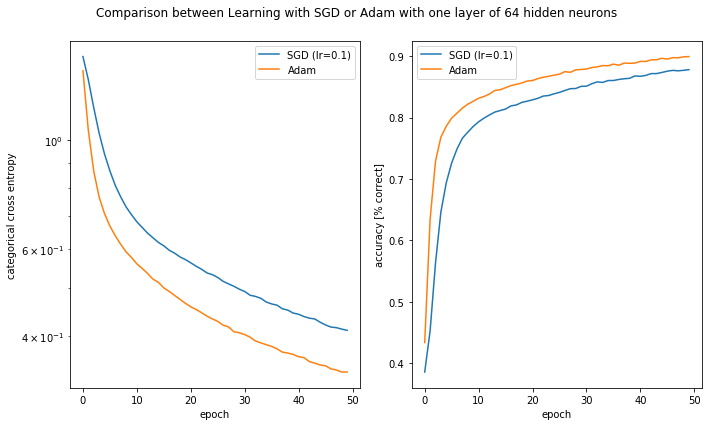

In [20]:
fig1, ax1, ax2 = prepare_standardplot('Comparison between Learning with SGD or Adam with one layer of 64 hidden neurons', 'epoch')
ax1.plot(history_sgd['loss'], label = "SGD (lr=0.1)")
ax1.plot(history_adam['loss'], label = "Adam")
ax2.plot(history_sgd['acc'], label = "SGD (lr=0.1)")
ax2.plot(history_adam['acc'], label = "Adam")
finalize_standardplot(fig1, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [ ]:
history_adam = adam_optimizer(N_hidden=64, K_hidden=1, ES_bool=False, epochs=1000, verbose=1)
plot_history(history_adam, "History adam")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [ ]:
#test
history_adam_10 = adam_optimizer(N_hidden=10, K_hidden=1, ES_bool=True, epochs=100, verbose=0)
plot_history(history_adam_10, "History adam 10 hidden units");

Try first for 100 different number of hidden neurons between 10 and 1000:

In [15]:
#THIS BLOCK TAKES A FEW HOURS TO RUN
history_list4 = {}
for i in range(10,1001,10): #takes approx. 4-5h
    history_tmp = adam_optimizer(N_hidden=i, K_hidden=1, ES_bool=True, epochs=1000, verbose=0)
    history_list4[i] = history_tmp.history
        
#save statistics in json
with open('SavedData/ex4_results.txt', 'w') as outfile:
    json.dump(history_list4, outfile)

Epoch 00050: early stopping
Test loss: 0.769558414309
Test accuracy: 0.778797613575
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
Epoch 00059: early stopping
Test loss: 0.613735055493
Test accuracy: 0.830503288952
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                5140      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 105       
Total params: 5,245
Trainable params: 

Test loss: 0.455422545106
Test accuracy: 0.876395900242
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 130)               33410     
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 655       
Total params: 34,065
Trainable params: 34,065
Non-trainable params: 0
_________________________________________________________________
Epoch 00039: early stopping
Test loss: 0.468837850695
Test accuracy: 0.87846106775
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 140)               35980     
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 705       
Total params: 36,685
Trainable params: 36,685
Non-trainable param

Epoch 00034: early stopping
Test loss: 0.454256744975
Test accuracy: 0.8815970629
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 260)               66820     
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 1305      
Total params: 68,125
Trainable params: 68,125
Non-trainable params: 0
_________________________________________________________________
Epoch 00026: early stopping
Test loss: 0.470504009963
Test accuracy: 0.87456019579
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 270)               69390     
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 1355      
Total params: 70,745
Trainable params: 

Test loss: 0.462079229884
Test accuracy: 0.881903013597
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 380)               97660     
_________________________________________________________________
dense_79 (Dense)             (None, 5)                 1905      
Total params: 99,565
Trainable params: 99,565
Non-trainable params: 0
_________________________________________________________________
Epoch 00028: early stopping
Test loss: 0.455950184825
Test accuracy: 0.879531895383
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 390)               100230    
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 1955      
Total params: 102,185
Trainable params: 102,185
Non-trainable pa

Test loss: 0.485310707925
Test accuracy: 0.881979501319
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 500)               128500    
_________________________________________________________________
dense_103 (Dense)            (None, 5)                 2505      
Total params: 131,005
Trainable params: 131,005
Non-trainable params: 0
_________________________________________________________________
Epoch 00027: early stopping
Test loss: 0.46101633632
Test accuracy: 0.879761358403
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 510)               131070    
_________________________________________________________________
dense_105 (Dense)            (None, 5)                 2555      
Total params: 133,625
Trainable params: 133,625
Non-trainable p

Test loss: 0.457490155616
Test accuracy: 0.879684870745
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 620)               159340    
_________________________________________________________________
dense_127 (Dense)            (None, 5)                 3105      
Total params: 162,445
Trainable params: 162,445
Non-trainable params: 0
_________________________________________________________________
Epoch 00024: early stopping
Test loss: 0.487245374715
Test accuracy: 0.870735811507
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 630)               161910    
_________________________________________________________________
dense_129 (Dense)            (None, 5)                 3155      
Total params: 165,065
Trainable params: 165,065
Non-trainable 

Test loss: 0.462036788737
Test accuracy: 0.878231604693
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 740)               190180    
_________________________________________________________________
dense_151 (Dense)            (None, 5)                 3705      
Total params: 193,885
Trainable params: 193,885
Non-trainable params: 0
_________________________________________________________________
Epoch 00029: early stopping
Test loss: 0.483781041411
Test accuracy: 0.876166437185
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 750)               192750    
_________________________________________________________________
dense_153 (Dense)            (None, 5)                 3755      
Total params: 196,505
Trainable params: 196,505
Non-trainable 

Test loss: 0.459197818412
Test accuracy: 0.883126816601
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 860)               221020    
_________________________________________________________________
dense_175 (Dense)            (None, 5)                 4305      
Total params: 225,325
Trainable params: 225,325
Non-trainable params: 0
_________________________________________________________________
Epoch 00027: early stopping
Test loss: 0.469970708445
Test accuracy: 0.881597062855
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 870)               223590    
_________________________________________________________________
dense_177 (Dense)            (None, 5)                 4355      
Total params: 227,945
Trainable params: 227,945
Non-trainable 

Test loss: 0.4879305851
Test accuracy: 0.880679210665
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 980)               251860    
_________________________________________________________________
dense_199 (Dense)            (None, 5)                 4905      
Total params: 256,765
Trainable params: 256,765
Non-trainable params: 0
_________________________________________________________________
Epoch 00031: early stopping
Test loss: 0.478221731028
Test accuracy: 0.882285452024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 990)               254430    
_________________________________________________________________
dense_201 (Dense)            (None, 5)                 4955      
Total params: 259,385
Trainable params: 259,385
Non-trainable pa

In [16]:
#read JSON file
with open('SavedData/ex4_results_every10.txt') as json_data:
    history_ex4 = json.load(json_data)

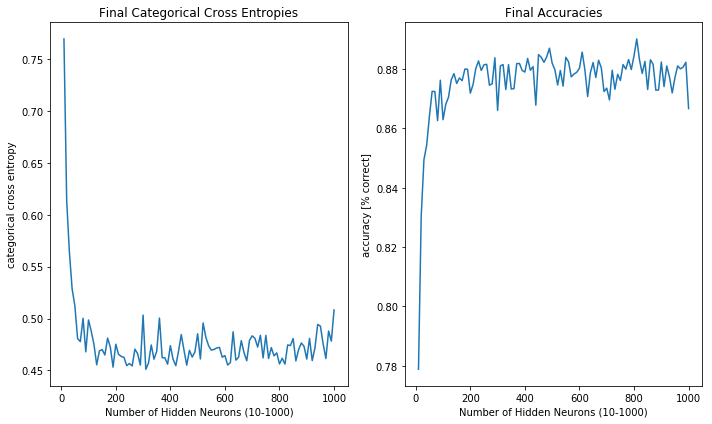

In [17]:
final_loss = []
final_acc = []

#keep all final accuracies and loss in lists
for i in range(10,1001,10):
    final_loss.append(history_ex4[str(i)]['val_loss'][-1])
    final_acc.append(history_ex4[str(i)]['val_acc'][-1])
    
#plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(10,1001,10),final_loss, label='Final categorical cross entropies');
ax1.set_ylabel('categorical cross entropy')
ax1.set_xlabel('Number of Hidden Neurons (10-1000)')
ax1.set_title('Final Categorical Cross Entropies');
ax2.plot(range(10,1001,10),final_acc, label='Final accuracies [% correct]');
ax2.set_ylabel('accuracy [% correct]')
ax2.set_xlabel('Number of Hidden Neurons (10-1000)')
ax2.set_title('Final Accuracies');
fig.tight_layout()

Now, fit models for 50, 100, 150 and 200 hidden neurons multiple times:

In [18]:
#THIS BLOCK TAKES A FEW HOURS TO RUN
history_list4_2 = {}
howmany = 20
N_H = [50,100,150,200]

for i in N_H:
    history_list4_2[i] = []
    #run 'howmany' times each model
    for j in range(0,howmany):
        history_tmp = adam_optimizer(N_hidden=i, K_hidden=1, ES_bool=True, epochs=1000, verbose=0)
        history_list4_2[i].append(history_tmp.history)
        
#save statistics in json
with open('SavedData/ex4_2_results.txt', 'w') as outfile:
    json.dump(history_list4_2, outfile)

Epoch 00072: early stopping
Test loss: 0.481790328944
Test accuracy: 0.875095609589
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 50)                12850     
_________________________________________________________________
dense_205 (Dense)            (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
Epoch 00051: early stopping
Test loss: 0.509063739117
Test accuracy: 0.862781092262
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 50)                12850     
_________________________________________________________________
dense_207 (Dense)            (None, 5)                 255       
Total params: 13,105
Trainable param

Test loss: 0.478189700848
Test accuracy: 0.876395900242
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 50)                12850     
_________________________________________________________________
dense_229 (Dense)            (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable params: 0
_________________________________________________________________
Epoch 00044: early stopping
Test loss: 0.537843251677
Test accuracy: 0.852914180808
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_230 (Dense)            (None, 50)                12850     
_________________________________________________________________
dense_231 (Dense)            (None, 5)                 255       
Total params: 13,105
Trainable params: 13,105
Non-trainable para

Epoch 00034: early stopping
Test loss: 0.507398770593
Test accuracy: 0.86507572279
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_254 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_255 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Epoch 00058: early stopping
Test loss: 0.485418034166
Test accuracy: 0.875631023433
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_257 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params

Test loss: 0.472923560182
Test accuracy: 0.876625363298
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_278 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_279 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
Epoch 00037: early stopping
Test loss: 0.498126332879
Test accuracy: 0.865228698198
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_281 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable para

Epoch 00034: early stopping
Test loss: 0.469718058225
Test accuracy: 0.873412880508
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_304 (Dense)            (None, 150)               38550     
_________________________________________________________________
dense_305 (Dense)            (None, 5)                 755       
Total params: 39,305
Trainable params: 39,305
Non-trainable params: 0
_________________________________________________________________
Epoch 00047: early stopping
Test loss: 0.484677196078
Test accuracy: 0.874713171152
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 150)               38550     
_________________________________________________________________
dense_307 (Dense)            (None, 5)                 755       
Total params: 39,305
Trainable param

Test loss: 0.498138291073
Test accuracy: 0.863622456803
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_328 (Dense)            (None, 200)               51400     
_________________________________________________________________
dense_329 (Dense)            (None, 5)                 1005      
Total params: 52,405
Trainable params: 52,405
Non-trainable params: 0
_________________________________________________________________
Epoch 00032: early stopping
Test loss: 0.458671919374
Test accuracy: 0.878690530852
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_330 (Dense)            (None, 200)               51400     
_________________________________________________________________
dense_331 (Dense)            (None, 5)                 1005      
Total params: 52,405
Trainable params: 52,405
Non-trainable para

Epoch 00032: early stopping
Test loss: 0.466697139506
Test accuracy: 0.876472387973
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_354 (Dense)            (None, 200)               51400     
_________________________________________________________________
dense_355 (Dense)            (None, 5)                 1005      
Total params: 52,405
Trainable params: 52,405
Non-trainable params: 0
_________________________________________________________________
Epoch 00040: early stopping
Test loss: 0.468810974726
Test accuracy: 0.878843506214
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 200)               51400     
_________________________________________________________________
dense_357 (Dense)            (None, 5)                 1005      
Total params: 52,405
Trainable param

In [29]:
#read JSON file
with open('SavedData/ex4_results_20times.txt') as json_data:
    history_ex4_2 = json.load(json_data)

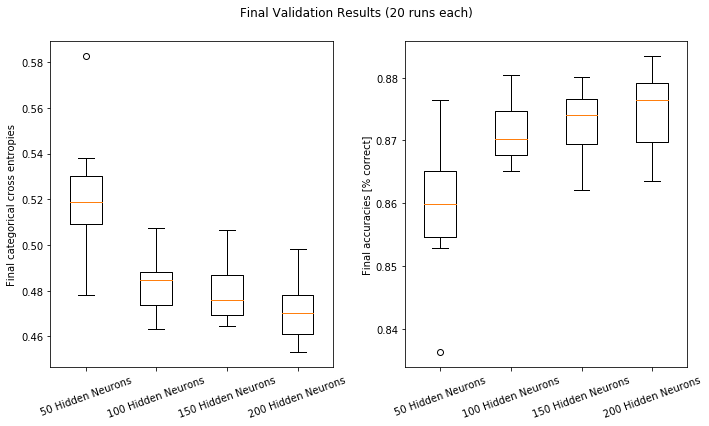

In [63]:
final_loss = []
final_acc = []

#keep all final accuracies and loss in lists
for k in N_H:
    loss_tmp = []
    acc_tmp = []
    for i in range(0,howmany):
        loss_tmp.append(history_ex4_2[str(k)][i]['val_loss'][-1])
        acc_tmp.append(history_ex4_2[str(k)][i]['val_acc'][-1])
    final_loss.append(loss_tmp)
    final_acc.append(acc_tmp)

#boxplot
fig, (ax1, ax2) = plt.subplots(1, 2)
labels = ['50 Hidden Neurons', '100 Hidden Neurons', '150 Hidden Neurons', '200 Hidden Neurons',]
ax1.boxplot(final_loss,labels=labels);
ax1.set_ylabel('Final categorical cross entropies')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=20)
ax2.boxplot(final_acc,labels=labels);
ax2.set_ylabel('Final accuracies [% correct]')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=20)
fig.suptitle('Final Validation Results ({} runs each)'.format(str(howmany)));
fig.tight_layout()
plt.subplots_adjust(top=0.9)

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

The number of parameters in a Deep Neural Network is:

$$ Nb_{parameters} = N_h \cdot [N_{in} + N_{out} + (N_h+1)\cdot(K-1)] + N_{out} $$

To find $ N_h $ to have always the same number of parameters as a network with one hidden layer of 100 neurons, one must solve:

$$ N_h²\cdot(K-1) + N_h\cdot(N_{in}+N_{out}+K-1)-100\cdot(N_{in}+N_{out}) = 0$$

In [57]:
#THIS BLOCK TAKES A FEW HOURS TO RUN
K = [2, 3, 4]
N_in = x_train.shape[1] +1  #256 + threshold
N_out = len(subset_of_classes) #5
history_list5 = {}

howmany = 20
            
#Equation to solve to find N_h
def f(x):
    return (x**2 *(k-1) + x *(N_in+N_out+k-1) - 100*(N_in+N_out))

for k in K:
    history_list5[k] = []
    #find N_h
    N_h = int(round(fsolve(f,0)[0]))
    #run 'howmany' times each model
    for i in range (0,howmany):        
        tmp_history = adam_optimizer(N_hidden=N_h, K_hidden=k, ES_bool=True, epochs=1000, verbose=0, SUMMARY=True)
        history_list5[k].append(tmp_history.history)
        
#save statistics in json
with open('SavedData/ex5_results.txt', 'w') as outfile:
    json.dump(history_list5, outfile)

Epoch 00040: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_676 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_677 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_678 (Dense)            (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
Epoch 00033: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_679 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_680 (Dense)            (None, 77)                6006      
________________

Epoch 00029: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_709 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_710 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_711 (Dense)            (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
Epoch 00020: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_712 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_713 (Dense)            (None, 77)                6006      
________________

Epoch 00035: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_744 (Dense)            (None, 66)                16962     
_________________________________________________________________
dense_745 (Dense)            (None, 66)                4422      
_________________________________________________________________
dense_746 (Dense)            (None, 66)                4422      
_________________________________________________________________
dense_747 (Dense)            (None, 5)                 335       
Total params: 26,141
Trainable params: 26,141
Non-trainable params: 0
_________________________________________________________________
Epoch 00035: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_748 (Dense)            (None, 66)                16962     
________________

Epoch 00038: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_784 (Dense)            (None, 66)                16962     
_________________________________________________________________
dense_785 (Dense)            (None, 66)                4422      
_________________________________________________________________
dense_786 (Dense)            (None, 66)                4422      
_________________________________________________________________
dense_787 (Dense)            (None, 5)                 335       
Total params: 26,141
Trainable params: 26,141
Non-trainable params: 0
_________________________________________________________________
Epoch 00026: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_788 (Dense)            (None, 66)                16962     
________________

Epoch 00025: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_826 (Dense)            (None, 59)                15163     
_________________________________________________________________
dense_827 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_828 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_829 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_830 (Dense)            (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________
Epoch 00024: early stopping
_________________________________________________________________
Layer (type)    

Epoch 00034: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_871 (Dense)            (None, 59)                15163     
_________________________________________________________________
dense_872 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_873 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_874 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_875 (Dense)            (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________
Epoch 00021: early stopping
_________________________________________________________________
Layer (type)    

In [58]:
#read JSON file
with open('SavedData/ex5_results.txt') as json_data:
    history_ex5 = json.load(json_data)

Comapre Curves of best accuracy and best cross entropy:

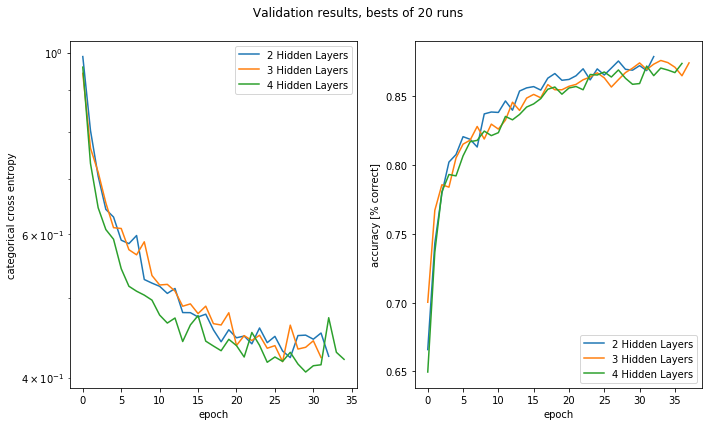

In [67]:
best_loss = {}
best_acc = {}

#find best accuracy results
for k in K:
    best_loss[k] = history_ex5[str(k)][0]['val_loss']
    best_acc[k] = history_ex5[str(k)][0]['val_acc']
    for i in range(0,howmany):
        loss = history_ex5[str(k)][i]['val_loss']
        acc = history_ex5[str(k)][i]['val_acc']        
        best_loss[k] = loss if loss[-1] < best_loss[k][-1] else best_loss[k]
        best_acc[k] = acc if acc[-1] > best_acc[k][-1] else best_acc[k]
                
#plot
fig, ax1, ax2 = prepare_standardplot(' Validation results, bests of {} runs'.format(str(howmany)), 'epoch')
for k in K:
    ax1.plot(best_loss[k], label = str(k)+" Hidden Layers")
    ax2.plot(best_acc[k], label = str(k)+" Hidden Layers")
finalize_standardplot(fig, ax1, ax2)

Make Boxplots of best results accross all models:

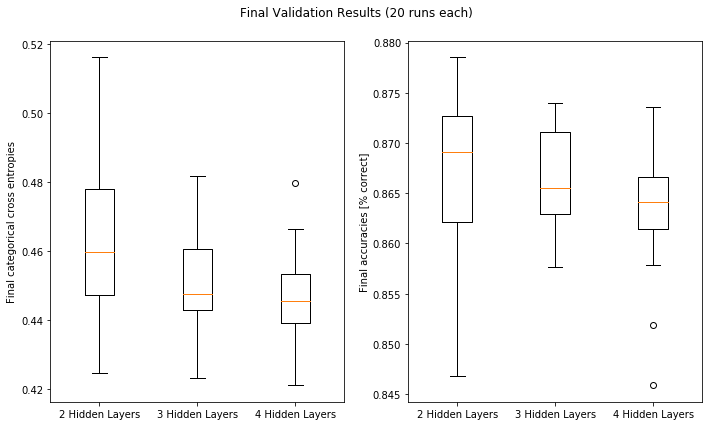

In [61]:
best_loss = []
best_acc = []

#keep all best accuracies and loss in lists
for k in K:
    loss_tmp = []
    acc_tmp = []
    for i in range(0,howmany):
        loss_tmp.append(history_ex5[str(k)][i]['val_loss'][-1])
        acc_tmp.append(history_ex5[str(k)][i]['val_acc'][-1])
    best_loss.append(loss_tmp)
    best_acc.append(acc_tmp)

#boxplot
fig, (ax1, ax2) = plt.subplots(1, 2)
labels = ['2 Hidden Layers', '3 Hidden Layers', '4 Hidden Layers']
ax1.boxplot(best_loss,labels=labels);
ax1.set_ylabel('Final categorical cross entropies')
ax2.boxplot(best_acc,labels=labels);
ax2.set_ylabel('Final accuracies [% correct]')
fig.suptitle('Final Validation Results ({} runs each)'.format(str(howmany)));
fig.tight_layout()
plt.subplots_adjust(top=0.9)

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

Try Batch Normalization Layers:

In [9]:
def plot_ex6(filename,title,label):
    #read JSON file
    with open(filename) as json_data:
        history_ex6 = json.load(json_data)
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    for i in range (len(label)):
        ax1.plot(history_ex6[str(i)]['loss'], label =label[i])
    for i in range(len(label)):
        ax2.plot(history_ex6[str(i)]['acc'], label = label[i]) 
    finalize_standardplot(fig, ax1, ax2)

In [10]:
def create_plain_models():
    import os.path
    if not os.path.exists('SavedData/ex6_plain_models_results.txt'):
        #Create a json with the plain models for 1x100 HN and 4x59 HN and put it in the beginning of history_list6
        plain_model = {}
        plain_model[0]= adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,dropout=0,SUMMARY=True).history
        plain_model[1] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,dropout=0,SUMMARY=True).history
        #save statistics in json
        with open('SavedData/ex6_plain_models_results.txt', 'w') as outfile:
            json.dump(plain_model, outfile)

In [18]:
if not 'history_list6' in globals():
    history_list6 = {}
    create_plain_models()
    with open('SavedData/ex6_plain_model_results.txt') as json_data:
        history_list6 = json.load(json_data)

#one hidden layer 100 neurons WITH batch normalization
history_list6[2] = adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,BN_bool=True,SUMMARY=True).history
#four hidden layers WITH batch normalization
history_list6[3] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,BN_bool=True,SUMMARY=True).history

#save statistics in json
with open('SavedData/ex6_1_results.txt', 'w') as outfile:
    json.dump(history_list6, outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 100)               25700     
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 100)               25700     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 505       
Total params: 26,605
Trainable params: 26,405
Non-trainable params: 200


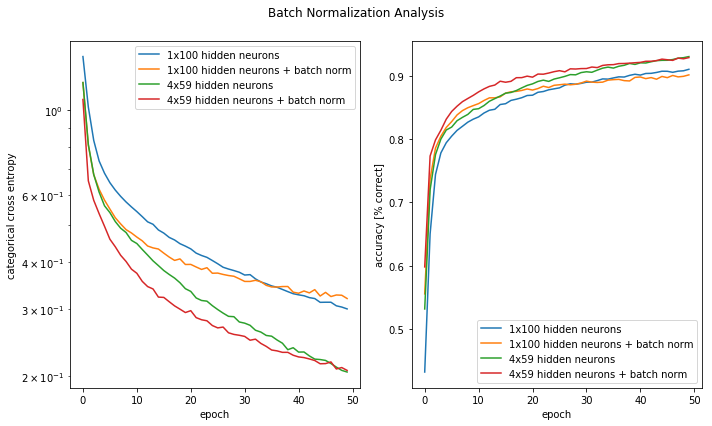

In [15]:
filename='SavedData/ex6_1_results.txt'
title = 'Batch Normalization Analysis'
label = ['1x100 hidden neurons','1x100 hidden neurons + batch norm','4x59 hidden neurons','4x59 hidden neurons + batch norm']
plot_ex6(filename,title,label)

Try Dropout Layers:

In [21]:
if not 'history_list6' in globals():
    history_list6 = {}
    create_plain_models()
    with open('SavedData/ex6_plain_model_results.txt') as json_data:
        history_list6 = json.load(json_data)

#one hidden layer 100 neurons WITH dropout 0.2
history_list6[2] = adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,dropout=0.2,SUMMARY=True).history
#one hidden layer 100 neurons WITH dropout 0.5
history_list6[3] = adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,dropout=0.5,SUMMARY=True).history
#four hidden layers WITH dropout 0.2
history_list6[4] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,dropout=0.2,SUMMARY=True).history
#four hidden layers WITH dropout 0.5
history_list6[5] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,dropout=0.5,SUMMARY=True).history
#save statistics in json
with open('SavedData/ex6_2_results.txt', 'w') as outfile:
    json.dump(history_list6, outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 59)                15163     
_________________________________________________________________
dense_8 (Dense)              (None, 59)                3540      
_________________________________________________________________
dense_9 (Dense)              (None, 59)                3540      
_________________________________________________________________
dense_

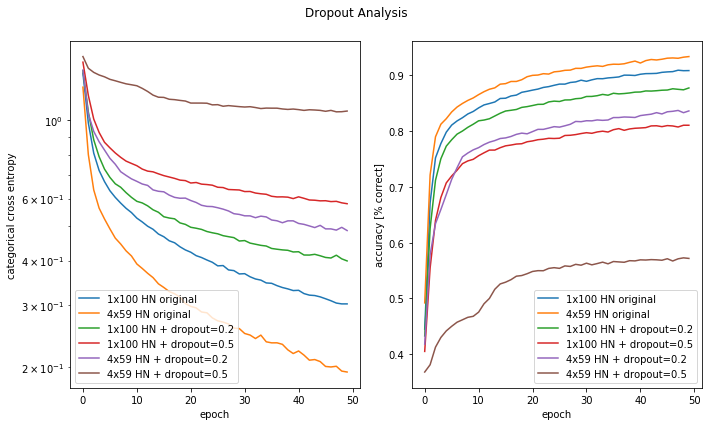

In [22]:
filename='SavedData/ex6_2_results.txt'
title = 'Dropout Analysis'
label = ['1x100 HN original','4x59 HN original','1x100 HN + dropout=0.2','1x100 HN + dropout=0.5','4x59 HN + dropout=0.2','4x59 HN + dropout=0.5']
plot_ex6(filename,title,label)

Try L1 Normalization:

In [21]:
if not 'history_list6' in globals():
    history_list6 = {}
    create_plain_models()
    with open('SavedData/ex6_plain_models_results.txt') as json_data:
        history_list6 = json.load(json_data)

#one hidden layer 100 neurons WITH L1 normalization
history_list6[2] = adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,L1_norm=0.01,SUMMARY=True).history
#four hidden layers WITH L1 normalization
history_list6[3] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,L1_norm=0.01,SUMMARY=True).history
#save statistics in json
with open('SavedData/ex6_3_results.txt', 'w') as outfile:
    json.dump(history_list6, outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 5)                 1285      
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 30        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 5)                 1285      
_________________________________________________________________
dense_39 (Dense)             (None, 59)                354       
_________________________________________________________________
dense_40 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_41

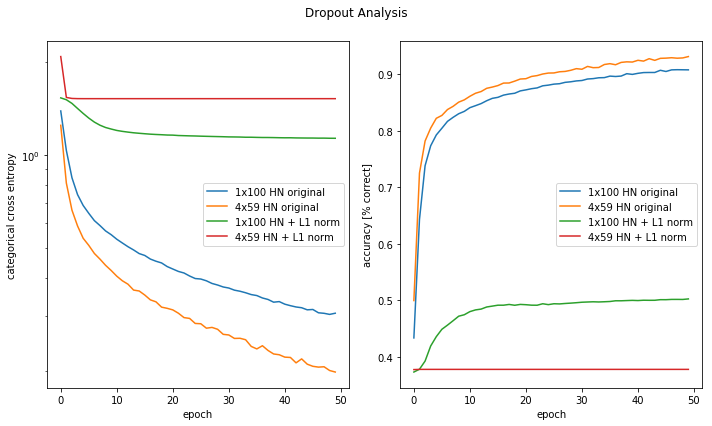

In [22]:
filename='SavedData/ex6_3_results.txt'
title = 'Dropout Analysis'
label = ['1x100 HN original','4x59 HN original','1x100 HN + L1 norm','4x59 HN + L1 norm']
plot_ex6(filename,title,label)

Try L2 Normalization:

In [19]:
if not 'history_list6' in globals():
    history_list6 = {}
    create_plain_models()
    with open('SavedData/ex6_plain_models_results.txt') as json_data:
        history_list6 = json.load(json_data)

#one hidden layer 100 neurons WITH L1 normalization
history_list6[2] = adam_optimizer(K_hidden=1,N_hidden=100,epochs=50,L2_norm=0.01,SUMMARY=True).history
#four hidden layers WITH L1 normalization
history_list6[3] = adam_optimizer(K_hidden=4,N_hidden=59,epochs=50,L2_norm=0.01,SUMMARY=True).history
#save statistics in json
with open('SavedData/ex6_4_results.txt', 'w') as outfile:
    json.dump(history_list6, outfile)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 5)                 1285      
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 30        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 5)                 1285      
_________________________________________________________________
dense_32 (Dense)             (None, 59)                354       
_________________________________________________________________
dense_33 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_34

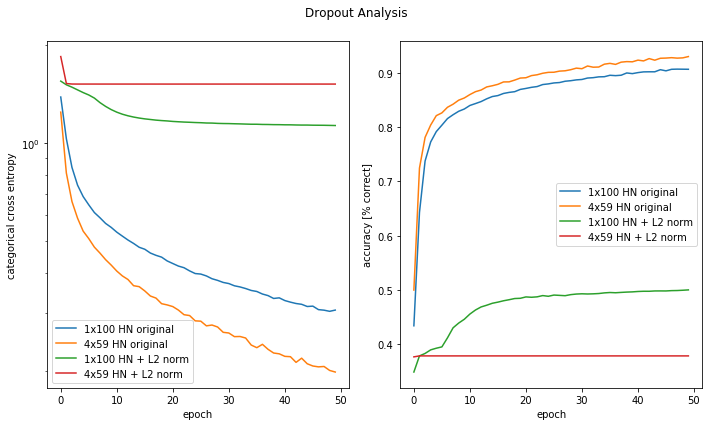

In [20]:
filename='SavedData/ex6_4_results.txt'
title = 'Dropout Analysis'
label = ['1x100 HN original','4x59 HN original','1x100 HN + L2 norm','4x59 HN + L2 norm']
plot_ex6(filename,title,label)

Plot new best model VS naive model:

Plot current model:

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution